In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#importing models that will be applied
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import statsmodels.api as sm

#some preprocessing tools to automate the data preperation
from sklearn.preprocessing import StandardScaler

#model evaluation metrics
from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# to ignore warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# magic to not to call show every time 
%matplotlib inline

In [62]:
data_raw = pd.read_csv('https://raw.githubusercontent.com/raffisahakyan/Raw_Data/master/Employee_attrition.csv')
data_raw.info()
print("\n"+"-"*80+'\n')
data_raw.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


In [63]:
data_numeric = data_raw.select_dtypes(exclude=["object"])
data_object = data_raw.select_dtypes(include=["object"])

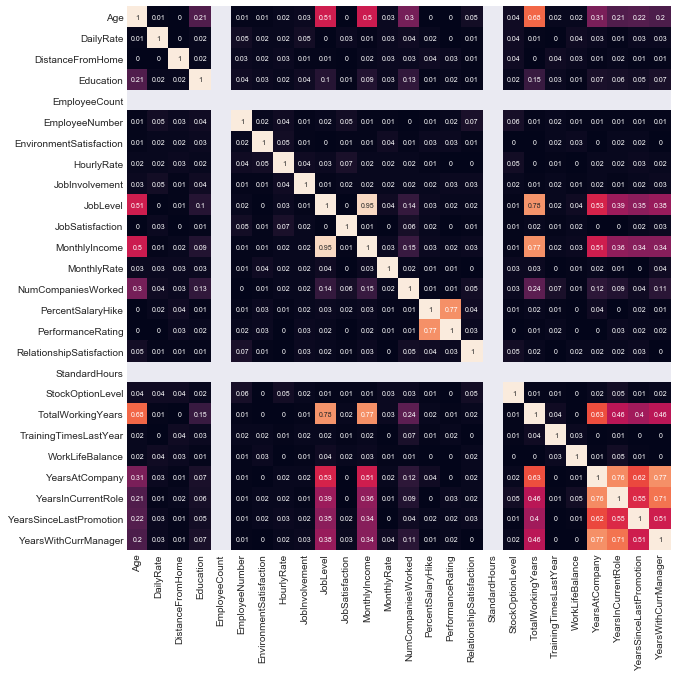

In [64]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(data_numeric.corr().abs().round(2), 
                 annot=True, annot_kws = { "size" : 7 }, square=True, cbar=False)

#### Q1. Are there any missing values?

In [65]:
print("There are ", data_raw.isna().sum().sum(), " missing values")

There are  0  missing values


#### Q1 continued. Plot the boxplot for all numeric variables.

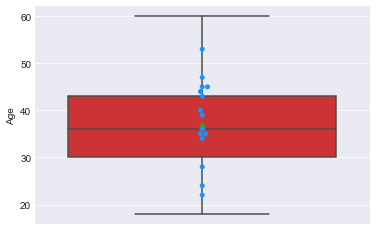

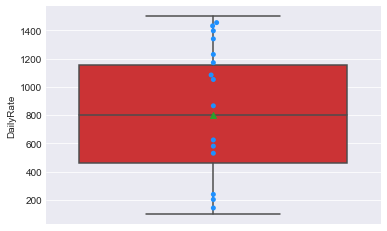

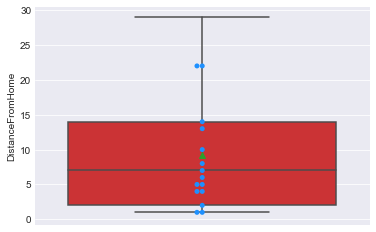

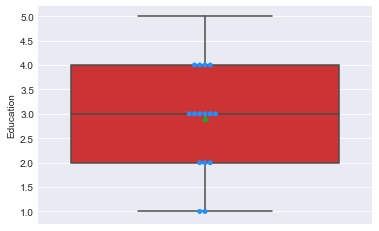

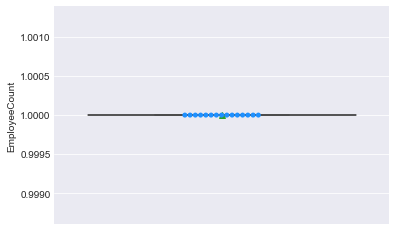

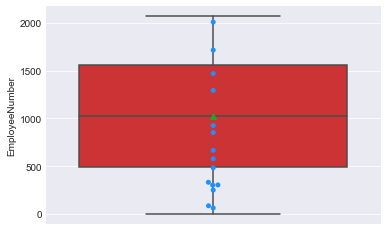

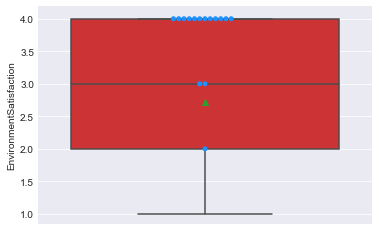

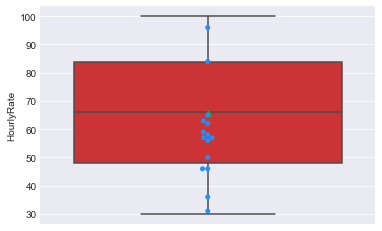

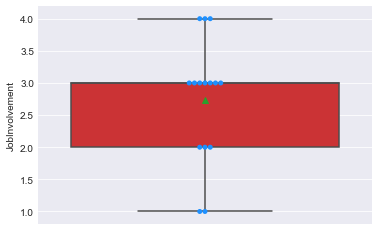

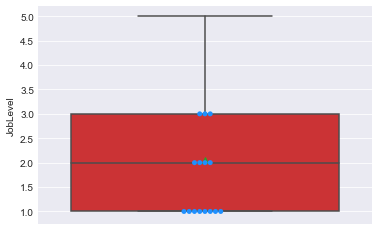

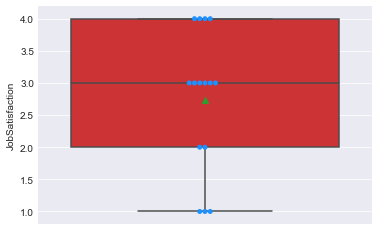

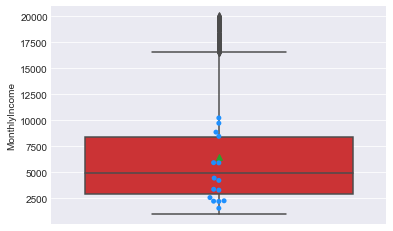

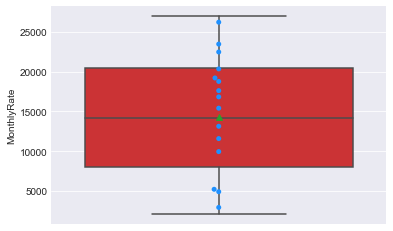

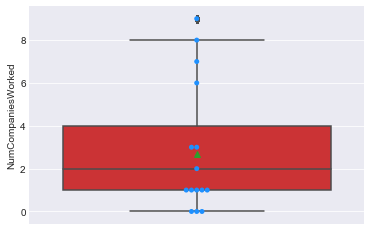

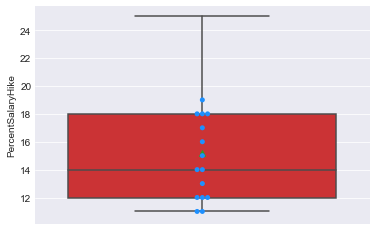

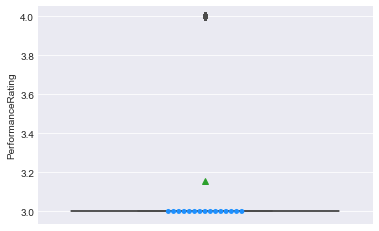

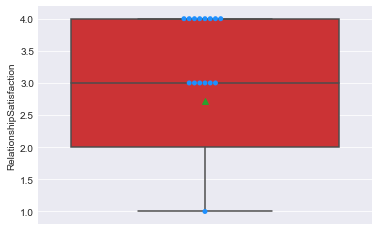

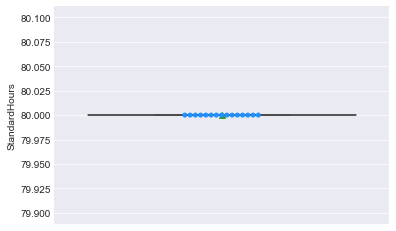

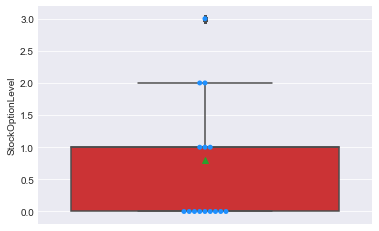

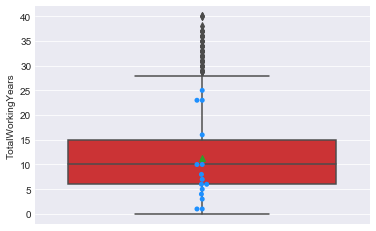

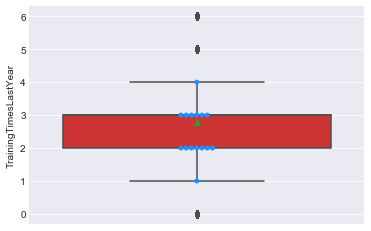

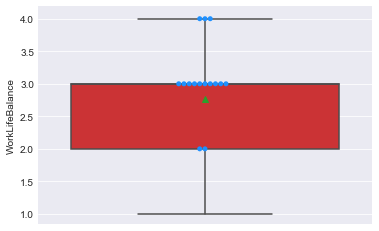

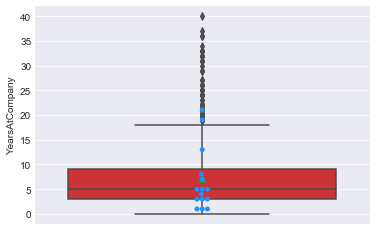

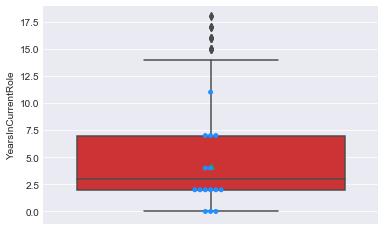

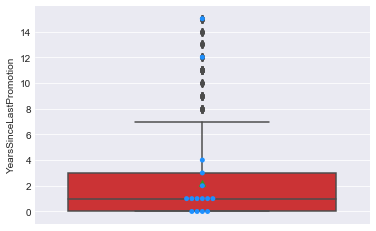

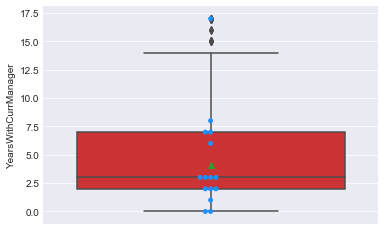

In [66]:
sns.set_style("darkgrid")
for i in data_numeric.columns:
    ax=sns.boxplot(y=data_numeric[i],palette='Set1',showmeans=True)
    ax = sns.swarmplot(y=data_numeric[i].sample(15, random_state=42), color='dodgerblue')
    plt.show()

#### Are there any outliers? If yes, then which variables have them?

In [67]:
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers_data=((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).sum().replace(0, np.nan).dropna(how='all').to_frame(name="Number of Outliers")
outliers_data.index.name = 'Variables Containing Outliers'

if (outliers_data["Number of Outliers"]>0).any():
    print("There are Outliers According to IQR Outlier Test Check")
else:
    print("There are No Outliers According to IQR Outlier Test Check")

There are Outliers According to IQR Outlier Test Check


In [68]:
outliers_data.sort_values(by="Number of Outliers", ascending=False)

,Number of Outliers
Variables Containing Outliers,
TrainingTimesLastYear,238.0
PerformanceRating,226.0
MonthlyIncome,114.0
YearsSinceLastPromotion,107.0
YearsAtCompany,104.0
StockOptionLevel,85.0
TotalWorkingYears,63.0
NumCompaniesWorked,52.0
YearsInCurrentRole,21.0


#### Q2. Use for loop to plot the histogram of all variables one after another.

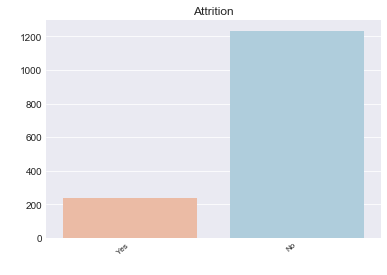

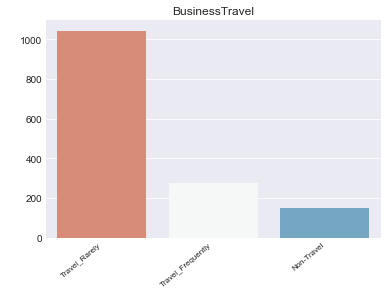

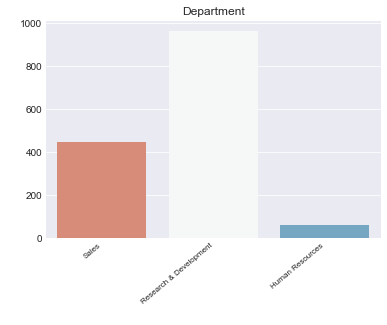

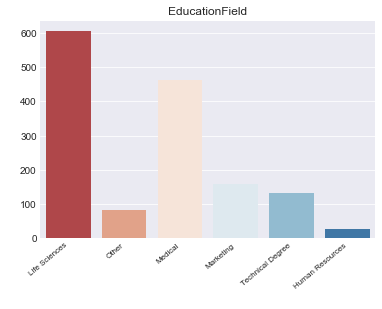

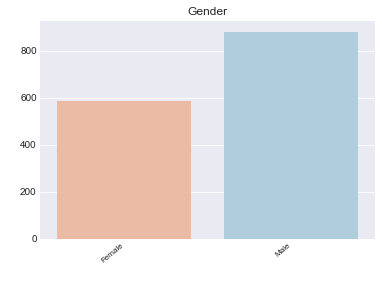

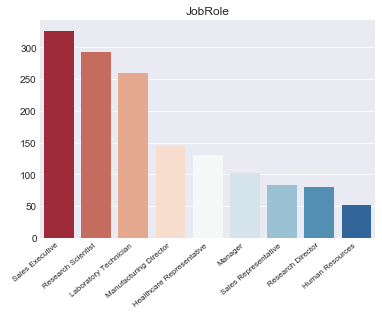

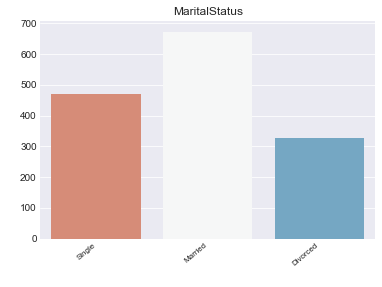

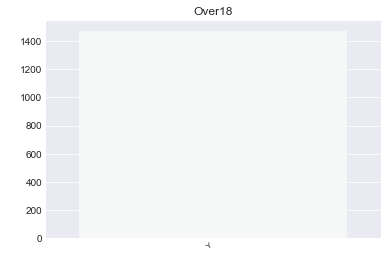

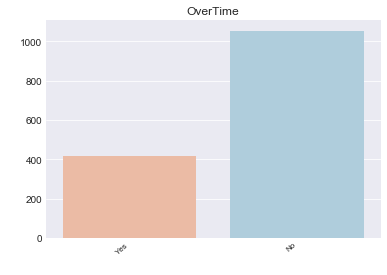

In [69]:
sns.set_style("darkgrid")
for i in data_object.columns:
    ax = sns.countplot(data_object[i], 
                       palette='RdBu')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, 
                       rotation=40, ha="right")
    ax.set_title(i)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.show()

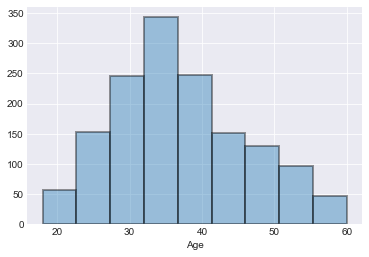

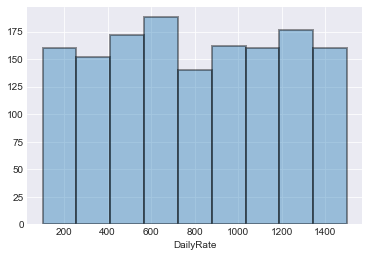

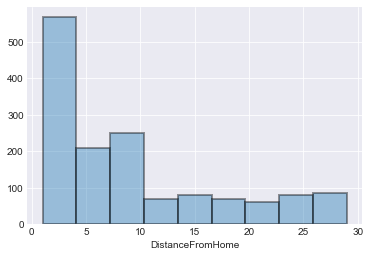

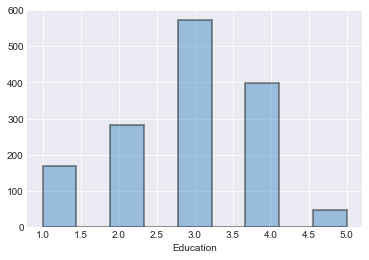

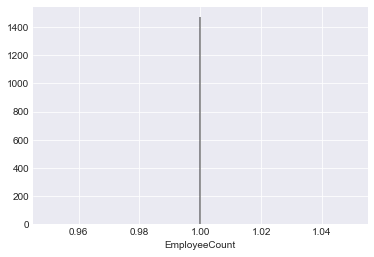

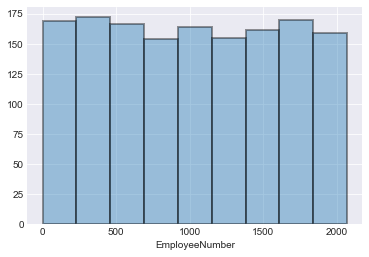

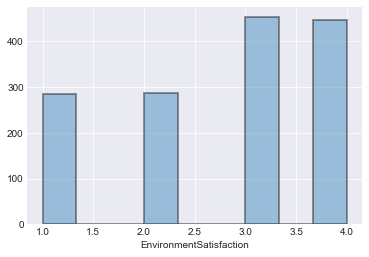

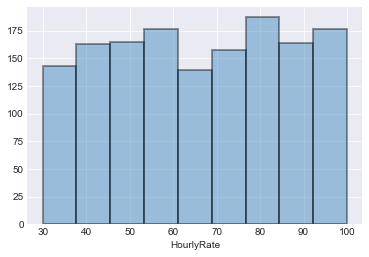

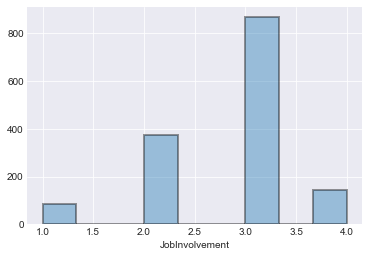

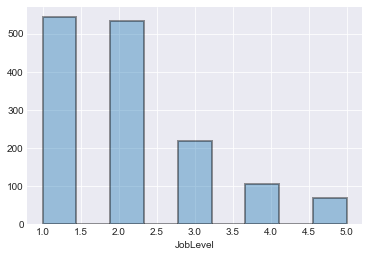

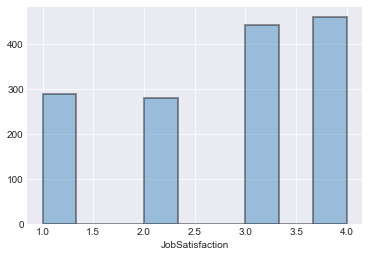

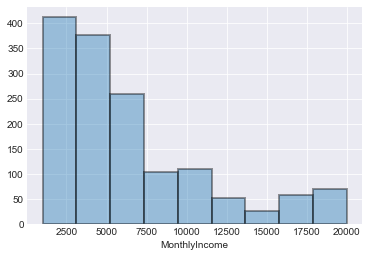

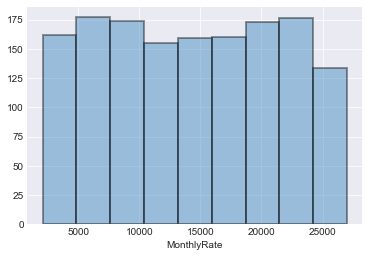

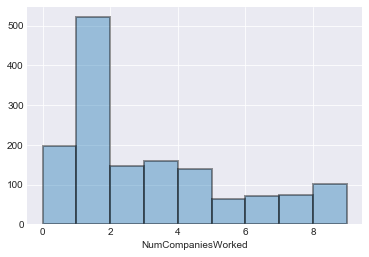

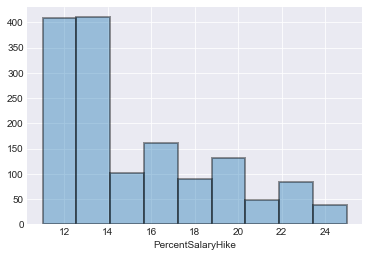

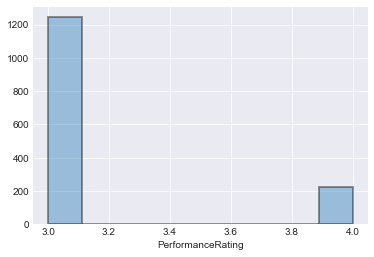

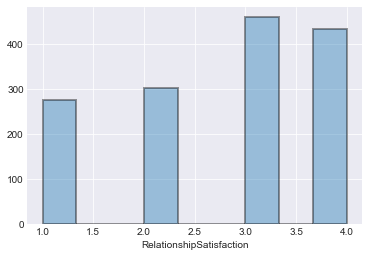

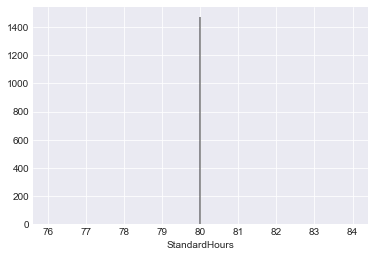

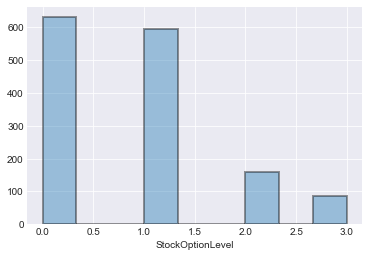

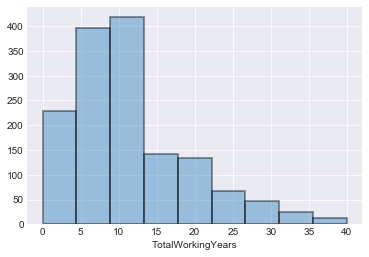

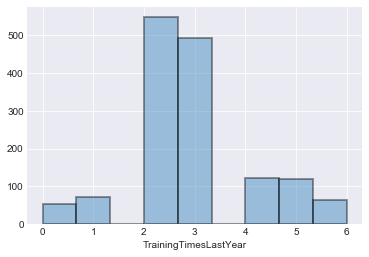

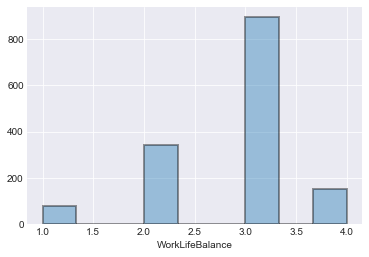

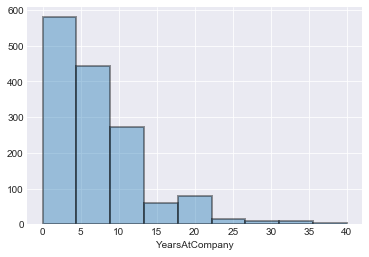

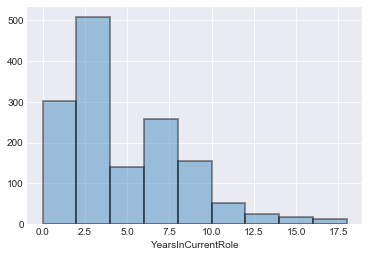

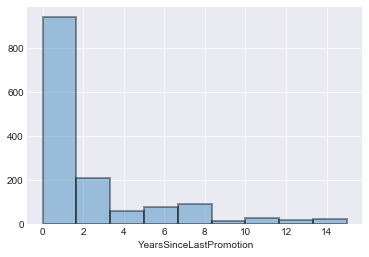

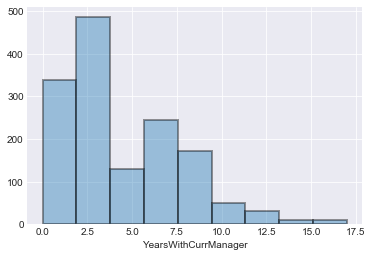

In [70]:
for i in data_numeric.columns:
    sns.distplot(data_numeric[i], kde=False, hist_kws=dict(edgecolor="k", linewidth=2), 
                 bins=np.linspace(math.ceil(min(data_numeric[i])),math.floor(max(data_numeric[i])),10))
    plt.show()

#### Q2 continued. Use the information from plots as well as any other relevant information (e.g. correlations, outliers) to transform your dataset to achieve better results. What are the changes that you implemented with your variables, that helped you increase your model performance?

Q2 Answer. To achieve better model results 1)I have dropped the variables that have zero variance, 2)reordered categories and created dummies to transform object type of variables to float type of variables since some models can not process the object type of entries, 3) I have regrouped the Age variable to groups of Age to have more informative variable, 4) finally I have scaled the independent variables sklearn.preprocessing.StandardScaler to minimize the impact of outliers on the dataset, since dropping outliers according to 1.5IQR rule would have a detrimental impact on the dataset. This function transforms the data by applying the z-score formula z = (x - u) / s, where the u is the mean and s is std.

In [71]:
data_raw = data_raw.loc[:,data_raw.apply(pd.Series.nunique) != 1]

In [72]:
data_raw['Attrition']=data_raw['Attrition'].astype("category").cat.reorder_categories(['No','Yes']).cat.codes 
data_raw['Gender']=data_raw['Gender'].astype("category").cat.reorder_categories(['Female','Male']).cat.codes 
data_raw['OverTime']=data_raw['OverTime'].astype("category").cat.reorder_categories(['No','Yes']).cat.codes 

In [73]:
data_raw.Age=pd.cut(data_raw.Age, 
                   bins=[data_raw.Age.min(),19,35,50,data_raw.Age.max()], 
                   labels=["GenerationZ", "Millenials", "GenerationX", "Baby_Boomers"])
data_raw.Age.head(2)

0    GenerationX
1    GenerationX
Name: Age, dtype: category
Categories (4, object): [GenerationZ < Millenials < GenerationX < Baby_Boomers]

In [74]:
dummies=pd.get_dummies(data_raw[['Age','MaritalStatus','JobRole','Department','EducationField','BusinessTravel']],
                       drop_first=True, prefix_sep='__')

In [75]:
#dropping also EmployeeNumber since it does not provide any additional information
data_raw.drop(['Age','MaritalStatus','JobRole',"Department",'EducationField','BusinessTravel', 'EmployeeNumber'], 
              axis=1, inplace=True)
data_clean = data_raw.join(dummies)

print(data_clean.head(2))
print("-"*30)
print(data_clean.info())

   Attrition  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0          1       1102                 1          2                        2   
1          0        279                 8          1                        3   

   Gender  HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  \
0       0          94               3         2                4   
1       1          61               2         2                2   

               ...                JobRole__Sales Representative  \
0              ...                                            0   
1              ...                                            0   

   Department__Research & Development  Department__Sales  \
0                                   0                  1   
1                                   1                  0   

   EducationField__Life Sciences  EducationField__Marketing  \
0                              1                          0   
1                              1          

In [76]:
scaler = StandardScaler()
scaler.fit(data_clean.drop('Attrition',axis=1)) 
x_scaled = pd.DataFrame(scaler.transform(data_clean.drop('Attrition',axis=1)),
                        columns = data_clean.drop('Attrition',axis=1).columns)
y=data_clean['Attrition']
x_train, x_test, y_train, y_test = train_test_split(x_scaled, 
                                                    y,test_size=.25, random_state=42, 
                                                    stratify=y)

#### Q3. Fill in the following table for the best models you come up with. Add columns if you developed additional/advanced models (e.g. Random Forest Classification or Gradient Boosting Classifier).

##### Logistic Regression

In [77]:
#In order to save time we will instantly start to search for the best hyperparameters for each model
model_logit = LogisticRegression(random_state=42, class_weight='balanced')
model_logit.fit(x_train,y_train)
print("Accuracy on train set",round(model_logit.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_logit.score(x_test,y_test)*100,3),"%")
logit_pred = model_logit.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,logit_pred),3))
print("Roc Auc Score",round(roc_auc_score(y_test,logit_pred)*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_logit,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean(),3))
print("-"*100)
print(confusion_matrix(y_test, logit_pred))
print("-"*100)
print(classification_report(y_test, logit_pred))

Accuracy on train set 79.583 %
Accuracy on test set 77.446 %
Mean Squared Error 0.226
Roc Auc Score 71.485 %
Mean of Cross-Validation Scores 0.836
----------------------------------------------------------------------------------------------------
[[248  61]
 [ 22  37]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.80      0.86       309
          1       0.38      0.63      0.47        59

avg / total       0.83      0.77      0.79       368



In [78]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C_param_range = [0.001,0.01,0.1,1,10,100,1000]

# Create hyperparameter options
hyperparameters = dict(C=C_param_range, penalty=penalty)

In [79]:
grid_logit = GridSearchCV(model_logit, hyperparameters, cv=5, scoring = 'roc_auc')
grid_logit.fit(x_train,y_train)
print(grid_logit.best_params_)

{'C': 0.01, 'penalty': 'l2'}


In [80]:
#Tuned Logistic Regression Model
model_logit_tuned = LogisticRegression(random_state=42, class_weight='balanced', C=0.01, penalty='l2', warm_start=True)
model_logit_tuned.fit(x_train,y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)

In [81]:
print("Accuracy on train set",round(model_logit_tuned.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_logit_tuned.score(x_test,y_test)*100,3),"%")

tuned_logit_pred = model_logit_tuned.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_logit_pred),3))

print("Roc Auc Score-Test",round(roc_auc_score(y_test,tuned_logit_pred)*100,3),"%")
print("Roc Auc Score-Train",round(roc_auc_score(y_train,model_logit_tuned.predict(x_train))*100,3),"%")

print("Recall-Test",round(recall_score(y_test,tuned_logit_pred)*100,3),"%")
print("Recall-Train",round(recall_score(y_train,model_logit_tuned.predict(x_train))*100,3),"%")

print("F1 score",round(f1_score(y_test,tuned_logit_pred, average='weighted')*100,3),"%")

print("Mean of Cross-Validation Scores",round(cross_val_score(model_logit_tuned,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")

Accuracy on train set 73.956 %
Accuracy on test set 75.0 %
Mean Squared Error 0.25
Roc Auc Score-Test 74.143 %
Roc Auc Score-Train 77.893 %
Recall-Test 72.881 %
Recall-Train 83.708 %
F1 score 77.869 %
Mean of Cross-Validation Scores 83.619 %


##### Decision Tree

In [82]:
model_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree.fit(x_train,y_train)

print("Accuracy on train set",round(model_tree.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_tree.score(x_test,y_test)*100,3),"%")

tree_pred = model_tree.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tree_pred),3))

print("Roc Auc Score",round(roc_auc_score(y_test,tree_pred)*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_tree,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")
print("-"*100)
print(confusion_matrix(y_test, tree_pred))
print("-"*100)
print(classification_report(y_test, tree_pred))

Accuracy on train set 100.0 %
Accuracy on test set 73.641 %
Mean Squared Error 0.264
Roc Auc Score 56.193 %
Mean of Cross-Validation Scores 61.168 %
----------------------------------------------------------------------------------------------------
[[253  56]
 [ 41  18]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.82      0.84       309
          1       0.24      0.31      0.27        59

avg / total       0.76      0.74      0.75       368



In [83]:
criterion_values = ['gini', 'entropy']
max_depth_values = [k for k in range(5,21)]
min_sample_values = [k for k in range(4,22,2)] #min samples leaf
min_samples_split_values = [k for k in range(6,16,2)] #min samples split
min_impurity_split_values = [k for k in range(0,6,2)]
max_features_values= ['auto', 'sqrt', 'log2']

grid_search_dt_parameters = {"max_depth":max_depth_values, 
                             "min_samples_leaf":min_sample_values, 
                             "min_samples_split":min_samples_split_values, 
                            "criterion":criterion_values, 
                             "min_impurity_split":min_impurity_split_values,
                            'max_features': max_features_values}

grid_search_dt=GridSearchCV(model_tree,grid_search_dt_parameters, scoring='roc_auc')
grid_search_dt.fit(x_train, y_train)
print(grid_search_dt.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_impurity_split': 0, 'min_samples_leaf': 20, 'min_samples_split': 6}


In [84]:
model_tree_tuned = DecisionTreeClassifier(random_state=42, class_weight = 'balanced', 
                                          criterion = 'gini', max_depth= 10, max_features= 'auto', 
                                          min_impurity_split= 0, min_samples_leaf= 20, min_samples_split= 6)
model_tree_tuned.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=0,
            min_samples_leaf=20, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [85]:
#Tuned Decision Tree
print("Accuracy on train set",round(model_tree_tuned.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_tree_tuned.score(x_test,y_test)*100,3),"%")

tuned_tree_pred = model_tree_tuned.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_tree_pred),3))

print("Roc Auc Score-Test",round(roc_auc_score(y_test,tuned_tree_pred)*100,3),"%")
print("Roc Auc Score-Train",round(roc_auc_score(y_train,model_tree_tuned.predict(x_train))*100,3),"%")

print("Recall-Test",round(recall_score(y_test,tuned_tree_pred)*100,3),"%")
print("Recall-Train",round(recall_score(y_train,model_tree_tuned.predict(x_train))*100,3),"%")

print("F1 score",round(f1_score(y_test,tuned_tree_pred, average='weighted')*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_tree_tuned,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")

Accuracy on train set 76.497 %
Accuracy on test set 69.837 %
Mean Squared Error 0.302
Roc Auc Score-Test 60.098 %
Roc Auc Score-Train 76.233 %
Recall-Test 45.763 %
Recall-Train 75.843 %
F1 score 72.892 %
Mean of Cross-Validation Scores 69.983 %


##### Random Forest

In [86]:
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf.fit(x_train,y_train)

print("Accuracy on train set",round(model_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_rf.score(x_test,y_test)*100,3),"%")

rf_pred = model_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,rf_pred),3))

print("Roc Auc Score",round(roc_auc_score(y_test,rf_pred)*100,3),"%")
print("F1 score",round(f1_score(y_test,rf_pred, average='weighted')*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_rf,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")
print("-"*100)
print(confusion_matrix(y_test, rf_pred))
print("-"*100)
print(classification_report(y_test, rf_pred))

Accuracy on train set 98.185 %
Accuracy on test set 84.511 %
Mean Squared Error 0.155
Roc Auc Score 53.752 %
F1 score 79.206 %
Mean of Cross-Validation Scores 69.475 %
----------------------------------------------------------------------------------------------------
[[306   3]
 [ 54   5]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.99      0.91       309
          1       0.62      0.08      0.15        59

avg / total       0.81      0.85      0.79       368



In [87]:
params_rf = {'max_depth': [i for i in range(2,17)],
          'max_features': [i for i in range(2,10,2)],
          'min_samples_leaf': [3,7,8,10],
          'min_samples_split': [z for z in range(4,21,2)],
          'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
          'bootstrap': [True, False]}

random_search_rf = RandomizedSearchCV(model_rf, param_distributions=params_rf, n_jobs=-1, scoring = 'roc_auc')
random_search_rf.fit(x_train,y_train)

tuned_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators= 2000, 
                                  min_samples_split= 16, min_samples_leaf= 7,
                                  max_features= 4, max_depth=10, bootstrap=True)
tuned_rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [88]:
print("Accuracy on train set",round(tuned_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(tuned_rf.score(x_test,y_test)*100,3),"%")

tuned_rf_pred = tuned_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_rf_pred),3))

print("Roc Auc Score-Test",round(roc_auc_score(y_test,tuned_rf_pred)*100,3),"%")
print("Roc Auc Score-Train",round(roc_auc_score(y_train,tuned_rf.predict(x_train))*100,3),"%")

print("Recall-Test",round(recall_score(y_test,tuned_rf_pred)*100,3),"%")
print("Recall-Train",round(recall_score(y_train,tuned_rf.predict(x_train))*100,3),"%")


print("F1 score",round(f1_score(y_test,tuned_rf_pred, average='weighted')*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(tuned_rf,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")

Accuracy on train set 94.192 %
Accuracy on test set 82.337 %
Mean Squared Error 0.177
Roc Auc Score-Test 62.056 %
Roc Auc Score-Train 91.094 %
Recall-Test 32.203 %
Recall-Train 86.517 %
F1 score 81.26 %
Mean of Cross-Validation Scores 80.112


##### Gradient Boosting

In [97]:
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(x_train,y_train)

print("Accuracy on train set",round(model_gb.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_gb.score(x_test,y_test)*100,3),"%")

gb_pred = model_gb.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,gb_pred),3))

print("Roc Auc Score",round(roc_auc_score(y_test,gb_pred)*100,3),"%")
print("F1 score",round(f1_score(y_test,gb_pred, average='weighted')*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_gb,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3))
print("-"*100)
print(confusion_matrix(y_test, gb_pred))
print("-"*100)
print(classification_report(y_test, gb_pred))

Accuracy on train set 96.189 %
Accuracy on test set 85.87 %
Mean Squared Error 0.141
Roc Auc Score 60.732 %
F1 score 82.923 %
Mean of Cross-Validation Scores 80.715
----------------------------------------------------------------------------------------------------
[[302   7]
 [ 45  14]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.98      0.92       309
          1       0.67      0.24      0.35        59

avg / total       0.84      0.86      0.83       368



In [98]:
params_gb = {'learning_rate' : [i for i in np.linspace(0.2,3,10)],
             'max_depth': [i for i in range(2,17)], 'max_features': range(6,20,2), 
             'min_samples_leaf': [6,7,10,13],
             'min_samples_split': [z for z in range(4,21,2)],
             'n_estimators':[int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)],
             'warm_start':[True, False]}

rand_search_gb = RandomizedSearchCV(model_gb, param_distributions=params_gb, scoring = 'roc_auc')
rand_search_gb.fit(x_train,y_train)

#Tuned Gradient Boosting
tuned_gb = GradientBoostingClassifier(random_state=42, warm_start= False, n_estimators=1783, min_samples_split= 10, 
                            min_samples_leaf= 7, max_features= 8, max_depth=8, learning_rate= 0.8222)
tuned_gb.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8222, loss='deviance', max_depth=8,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1783,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [99]:
print("Accuracy on train set",round(tuned_gb.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(tuned_gb.score(x_test,y_test)*100,3),"%")

tuned_gb_pred = tuned_gb.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_gb_pred),3))

print("Roc Auc Score-Test",round(roc_auc_score(y_test,tuned_gb_pred)*100,3),"%")
print("Roc Auc Score-Train",round(roc_auc_score(y_train,tuned_gb.predict(x_train))*100,3),"%")

print("Recall-Test",round(recall_score(y_test,tuned_gb_pred)*100,3),"%")
print("Recall-Train",round(recall_score(y_train,tuned_gb.predict(x_train))*100,3),"%")

print("F1 score",round(f1_score(y_test,tuned_gb_pred, average='weighted')*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(tuned_gb,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100,3),"%")

Accuracy on train set 100.0 %
Accuracy on test set 84.783 %
Mean Squared Error 0.152
Roc Auc Score-Test 60.084 %
Roc Auc Score-Train 100.0 %
Recall-Test 23.729 %
Recall-Train 100.0 %
F1 score 82.1 %
Mean of Cross-Validation Scores 75.568 %


##### Evaluation

Even though more sophisticated models provided better results for overall accuracy, the logistic regression is the choice that I will go for this particular dataset. Firstly, this model provides the opporunity to get the significant feature importances, it achieved the highest roc auc score on the test dataset and it provides the least overfitting out of 4 four models. Additionally, the Logistic Regression is the easiest to interpret for the stakeholders of this kind of business project.  

#### Q4 Continued. Which are the final important features that you will use with the selected model?

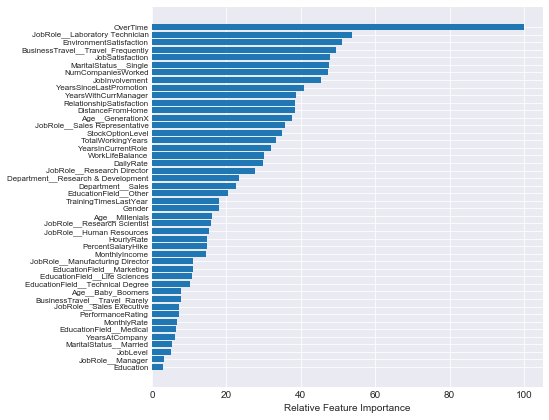

In [100]:
feature_importance_l = abs(model_logit_tuned.coef_[0])
feature_importance_l = 100.0 * (feature_importance_l / feature_importance_l.max())
sorted_idx = np.argsort(feature_importance_l)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(7,7))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance_l[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_scaled.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.show()
#However the sklearn.linear_model.LogisticRegression does not provide the p-values so we are not able to make
#any inference about the significance of each independent variable, for that reasons statsmodel 

In [101]:
model_l = sm.Logit(y, x_scaled)
model_stats_logit = model_l.fit()
summary_table = round(pd.DataFrame({"coeff":model_stats_logit.params,"pvals": model_stats_logit.pvalues}),4)
important_sum_table=summary_table.loc[summary_table['pvals'] < 0.05].loc[summary_table['coeff']>0].sort_values('coeff',
                                                                                                               ascending=False)
important_sum_table

Optimization terminated successfully.
         Current function value: 0.614088
         Iterations 7


,coeff,pvals
OverTime,0.4420,0.0000
BusinessTravel__Travel_Frequently,0.2984,0.0007
JobRole__Sales Representative,0.2829,0.0370
MaritalStatus__Single,0.2360,0.0165
JobRole__Laboratory Technician,0.2337,0.0224
NumCompaniesWorked,0.2150,0.0008
YearsSinceLastPromotion,0.1617,0.0278
DistanceFromHome,0.1394,0.0148


In [102]:
print("Final important features to be used for logistic regression:\n ", important_sum_table.index)

Final important features to be used for logistic regression:
  Index(['OverTime', 'BusinessTravel__Travel_Frequently',
       'JobRole__Sales Representative', 'MaritalStatus__Single',
       'JobRole__Laboratory Technician', 'NumCompaniesWorked',
       'YearsSinceLastPromotion', 'DistanceFromHome'],
      dtype='object')


#### Q5.Visualize (plot) the importance of selected features.

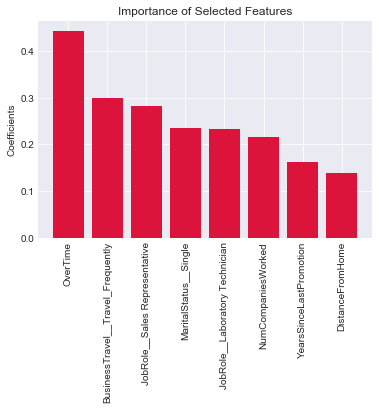

In [103]:
plt.bar(important_sum_table.index, important_sum_table['coeff'],color='crimson')
plt.title("Importance of Selected Features")
plt.ylabel('Coefficients')
plt.xticks(rotation=90)
plt.show()